In [15]:
# Load libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization

import tensorflow as tf # Deep Learning

In [16]:
df = pd.read_csv('Twitter_Data.csv') # Read the data only with the columns that we need
df.head() # Show the first 5 rows of the data
df2 = pd.read_csv('Reddit_Data.csv')
df2 = df2.rename(columns={'clean_comment': 'clean_text'})
df = pd.concat([df, df2])

In [17]:
df.dropna(inplace=True) # Drop the missing values

In [18]:
df['category'] = df['category'].apply(lambda x: 0 if x == -1 else (1 if x == 0 else 2)) # Convert the labels to numerical values

In [19]:
# function that converts a panda dataframe to a tensorflow dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=1024): # Function to convert a dataframe to a dataset
    df = dataframe.copy() # avoid modifying the original dataframe
    labels = df.pop("category") # Remove the label column from the dataframe
    df = df["clean_text"] # Keep only the description column
    ds = tf.data.Dataset.from_tensor_slices((df, labels)) # Create a tensorflow dataset
    if shuffle: # Shuffle the dataset if needed
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)  # Batch the dataset
    ds = ds.prefetch(tf.data.AUTOTUNE) # automatically tune the number of batches to prefetch based on the current runtime conditions
    return ds

In [20]:
train, val , test = np.split(df.sample(frac=1), [int(.8*len(df)), int(.9*len(df))]) # Split the data into train, validation and test sets with 80%, 10% and 10% of the data 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [21]:
train_data = df_to_dataset(train) # Convert the train dataframe to a tensorflow dataset
val_data = df_to_dataset(val) # Convert the validation dataframe to a tensorflow dataset
test_data = df_to_dataset(test) # Convert the test dataframe to a tensorflow dataset

In [22]:
# LSTM MODEL
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [23]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'modi', 'and', 'for', 'you', 'that', 'this',
       'are', 'not', 'will', 'india', 'with', 'have', 'but', 'has',
       'they', 'all', 'was'], dtype='<U15')

In [24]:
model2 = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [25]:
model2.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # gradient descent algorithm
    loss =  tf.keras.losses.SparseCategoricalCrossentropy(), # loss function
    metrics = ['accuracy']
)

In [26]:
model2.evaluate(train_data) # Evaluate the model on the test data

157/157 [==============================] - 80s 501ms/step - loss: 1.0989 - accuracy: 0.3089


[1.0989019870758057, 0.30887478590011597]

In [27]:
model2.evaluate(val_data) # Evaluate the model on the validation data

20/20 [==============================] - 9s 453ms/step - loss: 1.0989 - accuracy: 0.3109


[1.0988887548446655, 0.31091344356536865]

In [28]:
history = model2.fit(
    train_data,
    validation_data = val_data,
    epochs = 5
)

Epoch 1/5
157/157 [==============================] - 260s 2s/step - loss: 0.8136 - accuracy: 0.6448 - val_loss: 0.5399 - val_accuracy: 0.8127
Epoch 2/5
157/157 [==============================] - 255s 2s/step - loss: 0.4564 - accuracy: 0.8581 - val_loss: 0.3757 - val_accuracy: 0.8852
Epoch 3/5
157/157 [==============================] - 249s 2s/step - loss: 0.3783 - accuracy: 0.8896 - val_loss: 0.3590 - val_accuracy: 0.8934
Epoch 4/5
157/157 [==============================] - 250s 2s/step - loss: 0.3638 - accuracy: 0.8944 - val_loss: 0.3535 - val_accuracy: 0.8943
Epoch 5/5
157/157 [==============================] - 249s 2s/step - loss: 0.3539 - accuracy: 0.8973 - val_loss: 0.3512 - val_accuracy: 0.8950


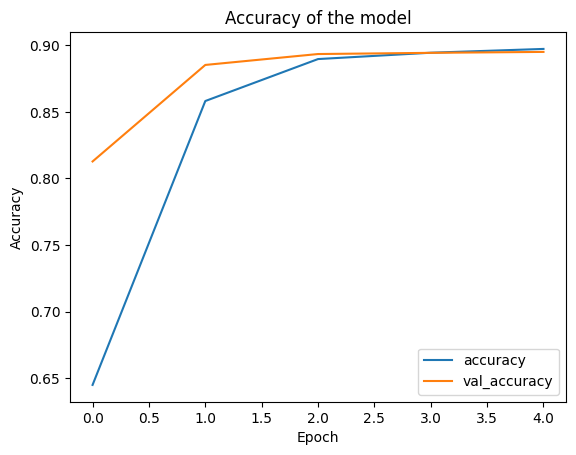

In [29]:
plt.plot(history.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(history.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
model2.evaluate(test_data) # Evaluate the model on the test data

20/20 [==============================] - 8s 434ms/step - loss: 0.3461 - accuracy: 0.8929


[0.34606051445007324, 0.8928642868995667]

In [33]:
def predict_sentiment(model, text):
    text = text.lower() # Convert the text to lowercase
    # Convert the text to a pandas DataFrame
    df = pd.DataFrame([text], columns=['Tweet'])

    # Convert the DataFrame to a tensorflow dataset
    ds = tf.data.Dataset.from_tensor_slices(df["Tweet"]).batch(1)

    # Use the model to predict the sentiment
    prediction = model.predict(ds)

    # Get the index of the maximum value (this will be the predicted label)
    predicted_label = np.argmax(prediction)

    # Map the numerical label back to the original label
    sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    predicted_sentiment = sentiment_map[predicted_label]

    # Print the predicted sentiment
    print(f"{text} is {predicted_sentiment}")

In [34]:
predict_sentiment(model2, "I am Gilad Fisher")
predict_sentiment(model2, "I am Barak Finkel")
predict_sentiment(model2, "I am Nikita Breslavsky")
predict_sentiment(model2, "I hate Nikita Breslavsky")
predict_sentiment(model2, "I love Nikita Breslavsky")
predict_sentiment(model2, "I love to kill people")
predict_sentiment(model2, "I dont love myself")

1/1 [==============================] - 0s 4ms/step
i am gilad fisher is Neutral
1/1 [==============================] - 0s 4ms/step
i am barak finkel is Neutral
1/1 [==============================] - 0s 3ms/step
i am nikita breslavsky is Neutral
1/1 [==============================] - 0s 4ms/step
i hate nikita breslavsky is Negative
1/1 [==============================] - 0s 4ms/step
i love nikita breslavsky is Positive
1/1 [==============================] - 0s 3ms/step
i love to kill people is Positive
1/1 [==============================] - 0s 4ms/step
i dont love myself is Positive
